This notebook generates Figure 2b in the Sei framework manuscript, showing that enhancer sequence classes near transcription start sites are correlated with relevant cell-type-specific gene expression. 

In [1]:
from collections import defaultdict
import os

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import tabix

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', titlesize=16)
mpl.rc('legend', fontsize=16)


In [3]:
RESOURCES_DIR = '../resources'
DATA_DIR = './data'
SEI_DIR = './sei_data'
FIGS_DIR = './figures'

In [4]:
SC_NAMES_FILE = os.path.join(RESOURCES_DIR, 'cnames.tsv')
df = pd.read_csv(SC_NAMES_FILE, sep='\t')
df.head()
MAPPING = {}
for row in df.itertuples():
    MAPPING[row.index] = '{0} {1}'.format(row.ID, row.name)

In [5]:
tabix_file = os.path.join(SEI_DIR, 'sorted.hg19.tiling.bed.ipca_randomized_300.labels.merged.bed.gz')
tabix_fh = tabix.open(tabix_file)

In [6]:
exp_df = pd.read_csv(
    os.path.join(DATA_DIR, 'geneanno.exp.csv'), index_col=0)
exp_df.head()

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Bladder,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,...,A549,GM12878.1,HELA,HEPG2,HMEC,HSMM,HUVEC,K562.1,NHEK,NHLF
1,17.473792,17.003800,11.349336,4.596447,5.394419,3.759323,22.725384,6.314982,4.257792,5.905298,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
2,14.282847,9.397430,0.046674,0.094502,0.491945,0.817776,0.123911,0.080094,0.110967,0.035388,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
3,22.491345,23.243749,29.331713,21.932945,21.226012,21.334572,20.613277,10.912875,12.926283,12.736749,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
4,4.539384,3.732321,4.271980,2.985295,3.410206,3.429678,7.219357,1.468935,1.472019,1.630884,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
5,1.048864,0.769213,0.658967,0.611572,0.725581,0.750336,1.142143,0.399902,0.284861,0.423821,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [7]:
gene_coords = pd.read_csv(os.path.join(DATA_DIR, 'geneanno.hg19.csv'))
gene_coords.rename(
    index={i: i + 1 for i in range(gene_coords.shape[0])},
    inplace=True)
gene_coords.head()

,id,symbol,seqnames,strand,TSS,CAGE_representative_TSS,type
1,ENSG00000000003,TSPAN6,chrX,-,99894988,99891748,protein_coding
2,ENSG00000000005,TNMD,chrX,+,99839799,99839933,protein_coding
3,ENSG00000000419,DPM1,chr20,-,49575092,49575069,protein_coding
4,ENSG00000000457,SCYL3,chr1,-,169863408,169863037,protein_coding
5,ENSG00000000460,C1orf112,chr1,+,169631245,169764186,protein_coding


In [8]:
N_from_TSS = 10000
gene_clustervec = {}
for row in gene_coords.itertuples():
    chrom = row.seqnames
    pos = row.CAGE_representative_TSS
    tss_start = pos - N_from_TSS
    tss_end = pos + N_from_TSS
    gene_id = (row.id, row.symbol)
    gene_clustervec[gene_id] = np.zeros(61)
    tabix_rows = tabix_fh.query(chrom, tss_start, tss_end)
    for r in tabix_rows:
        s = max(tss_start, int(r[1]))
        e = min(tss_end, int(r[2]))
        c = int(r[3])
        gene_clustervec[gene_id][c] += e - s

In [9]:
gene_cluster_mat = np.zeros((len(gene_clustervec), 61))
for i, (ensg, sym) in enumerate(
        zip(gene_coords['id'], gene_coords['symbol'])):
    gene_cluster_mat[i] = gene_clustervec[(ensg, sym)]

Normalize by tissue-average

In [10]:
gtex_expmat = exp_df.values[:, :53]
norm_gtex_tissues = np.log(gtex_expmat + 0.0001) - \
                    np.log(gtex_expmat + 0.0001).mean(axis=1)[:, None]

In [11]:
roadmap_expmat = exp_df.values[:, 53:]
norm_roadmap_tissues = np.log(roadmap_expmat + 0.01) - \
                       np.log(roadmap_expmat + 0.01).mean(axis=1)[:, None]

In [12]:
expmat = np.hstack([norm_gtex_tissues, norm_roadmap_tissues])

Compute correlations of sequence class annotations and tissue-specific gene expression

In [13]:
N_seqclasses = 40
correlations = np.zeros((expmat.shape[1], N_seqclasses))
pvalues = np.zeros((expmat.shape[1], N_seqclasses))
tissue_labels = []
for i, t in enumerate(exp_df.columns):
    for c in range(N_seqclasses):
        r, pv = spearmanr(gene_cluster_mat[:, c], 
                          expmat[:, i])
        correlations[i, c] = r
        pvalues[i, c] = pv
    tissue_labels.append(t)
tissue_labels = np.array(tissue_labels)

In [14]:
enhancer_classes = []
for c, desc in MAPPING.items():
    if 'E' == MAPPING[c].split(' ')[0][0]:
        enhancer_classes.append(c)
enhancer_classes

[12, 16, 36, 38, 5, 30, 7, 26, 6, 9, 17, 13]

In [15]:
USE_TISSUES = [
    'Cells_EBV-transformed_lymphocytes',
    'Peripheral_Blood_Mononuclear_Primary_Cells',
    'Thymus',
    'K562.1',
    'hESC_Derived_CD184+_Endoderm_Cultured_Cells',
    'HUES64_Cell_Line',
    'Brain_Cortex',
    'melanocyte of skin',
    'Fetal_Intestine_Small',
    'fibroblast of lung',
    'Skin_Sun_Exposed_Lower_leg',
    'Breast_Mammary_Tissue']

In [16]:
tiss_to_ix = {t: ix for (ix, t) in enumerate(tissue_labels)}
tiss_use_ixs = [tiss_to_ix[t] for t in USE_TISSUES]

/mnt/home/kchen/anaconda3/envs/sei-manu/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


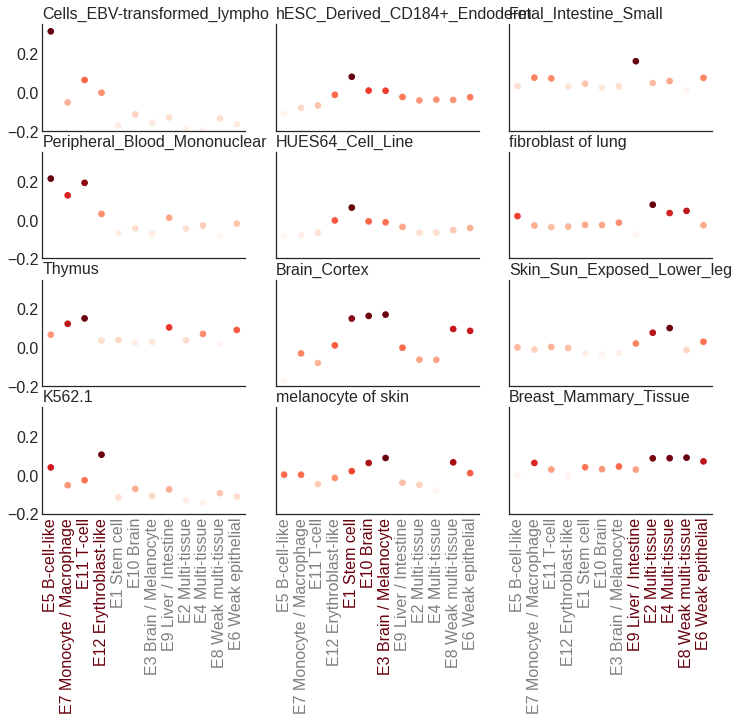

In [17]:
fig, axes = plt.subplots(
    4, 3,
    sharex=True, sharey=True,
    gridspec_kw=dict(wspace=0.15,),
    figsize=(12, 9))
xs = list(range(len(enhancer_classes)))
column_top_ixs = defaultdict(list)
for i, t in enumerate(USE_TISSUES):
    x = i % 4
    y = i // 4
    axes[x, y].set_title(t[:28], loc='left')
    corrs = correlations[:, enhancer_classes][tiss_to_ix[t]]
    column_top_ixs[y].append(np.argmax(corrs))
    axes[x, y].scatter(xs, corrs, s=32, c=corrs, cmap='Reds',)
    axes[x, y].set_xlim([-0.5, np.max(xs) + 0.5])
    axes[x, y].set_ylim([-0.2, 0.35])
    axes[x, y].xaxis.set_ticks(xs)
    axes[x, y].set_xticklabels([MAPPING[c] for c in enhancer_classes], rotation=90)
section_ixs = []
for c, top_ixs in column_top_ixs.items():
    s = np.min(top_ixs)
    section_ixs.append(s)
section_ixs.append(len(enhancer_classes))
for i, start in enumerate(section_ixs[:-1]):
    end = section_ixs[i + 1]
    for ix, xt in enumerate(axes[-1, i].get_xticklabels()):
        if ix >= start and ix < end:
            xt.set_color("#68010e")
        else:
            xt.set_color('gray')
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, 'enh_gene_expr_corrs.scatter.3col.pdf'), 
            dpi=300, bbox_inches='tight')